In [4]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
print(now_str())
print(torch.__version__)

9.2
[06/14 13:34:47]
1.4.0


In [156]:
y = np.float32([0, 1])
batch_size = 2
n_batch = len(y) // batch_size
loss_type = 'L1'
print('batch_size={}, n_batch={}'.format(batch_size, n_batch))
device = torch.device("cuda:0")

batch_size=2, n_batch=1


In [634]:
def plot(save_dir, loss_type, e, lr, losses, values, grads):
    fig, ax = plt.subplots(1, 3, figsize=(15, 3), tight_layout=True)
    a_loss = ax[0]
    a_val = ax[1]
    a_grad = ax[2]
    
    legends = []
    for k, v in losses.items():
        if k == 'total':
            a_loss.plot(v, linewidth=3)
        else:
            a_loss.plot(v)
        legends.append(k)
    a_loss.legend(legends)
    a_loss.set_title('[{}] {} Losses\nlr={:6f}, loss={:6f}'.format(e, loss_type, lr, losses['total'][-1]))
    a_loss.grid(True)
    
    legends = []
    for k, v in values.items():
        v = np.float32(v).transpose()
        if k == 'y_true':
            linestyle = '--'
            linewidth = 3
        else:
            linestyle = '-'
            linewidth = 1
        for n in range(len(v)):
            a_val.plot(v[n], linestyle=linestyle, linewidth=linewidth)
            legends.append('{}_{}'.format(k, n))
    a_val.set_title('Values\nx={:.4f}, y_hats={}'.format(values['x'][-1][0], values['y_hat'][-1]))
    a_val.legend(legends)
    a_val.grid(True)
    
    legends = []
    for k, v in grads.items():
        a_grad.plot(v)
        legends.append(k)
    a_grad.set_title('Gradients')
    a_grad.legend(legends)
    a_grad.grid(True)
    
    if save_dir is not None:
        save_path = save_dir + '/plot_{}.png'.format(e)
        plt.savefig(save_path, dpi=150)
        plot_img = imageio.imread(save_path)
        plt.close('all')
        return plot_img
    else:
        plt.close('all')
        return None
    
def plot_2(save_dir, loss_type, e, lr, losses, values, grads, losses_np, values_np, grads_np):
    fig, ax = plt.subplots(2, 3, figsize=(15, 6), tight_layout=True)
    # ================ #
    # plot pytorch
    # ================ #
    a_loss = ax[0, 0]
    a_val = ax[0, 1]
    a_grad = ax[0, 2]
    
    legends = []
    for k, v in losses.items():
        if k == 'total':
            a_loss.plot(v, linewidth=2)
        else:
            a_loss.plot(v)
        legends.append(k)
    a_loss.legend(legends)
    a_loss.set_title('PyTorch [{}] | {} Losses\nlr={:6f}, loss={:6f}'.format(e, loss_type, lr, losses['total'][-1]))
    a_loss.grid(True)
    
    legends = []
    for k, v in values.items():
        v = np.float32(v).transpose()
        if k == 'y_true':
            linestyle = '--'
            linewidth = 2
        else:
            linestyle = '-'
            linewidth = 1
        for n in range(len(v)):
            a_val.plot(v[n], linestyle=linestyle, linewidth=linewidth)
            legends.append('{}_{}'.format(k, n))
            
            if k == 'y_hat' and n == 0:
                break
#     a_val.set_title('Values\nx={}, y_hats={}'.format(values['x'][-1], values['y_hat'][-1]))
    a_val.set_title('Values\nx={}'.format(values['x'][-1]))
    a_val.legend(legends, bbox_to_anchor=(0.95, 0.1), loc="lower right")
    a_val.grid(True)
    
    legends = []
    for k, v in grads.items():
        a_grad.plot(v)
        legends.append(k)
    a_grad.set_title('Gradients')
    a_grad.legend(legends)
    a_grad.grid(True)
    
    
    # ================ #
    # plot numpy
    # ================ #
    a_loss = ax[1, 0]
    a_val = ax[1, 1]
    a_grad = ax[1, 2]
    
    legends = []
    for k, v in losses_np.items():
        if k == 'total':
            a_loss.plot(v, linewidth=2)
        else:
            a_loss.plot(v)
        legends.append(k)
    a_loss.legend(legends)
    a_loss.set_title('Numpy [{}] | {} Losses\nlr={:6f}, loss={:6f}'.format(e, loss_type, lr, losses_np['total'][-1]))
    a_loss.grid(True)
    
    legends = []
    for k, v in values_np.items():
        v = np.float32(v).transpose()
        if k == 'y_true':
            linestyle = '--'
            linewidth = 2
        else:
            linestyle = '-'
            linewidth = 1
        for n in range(len(v)):
            a_val.plot(v[n], linestyle=linestyle, linewidth=linewidth)
            legends.append('{}_{}'.format(k, n))
            
            if k == 'y_hat' and n == 0:
                break
                
    #a_val.set_title('Values\nx={}, y_hats={}'.format(values_np['x'][-1], values_np['y_hat'][-1]))
    a_val.set_title('Values\nx={}'.format(values_np['x'][-1]))
    a_val.legend(legends, bbox_to_anchor=(0.95, 0.1), loc="lower right")
    a_val.grid(True)
    
    legends = []
    for k, v in grads_np.items():
        a_grad.plot(v)
        legends.append(k)
    a_grad.set_title('Gradients')
    a_grad.legend(legends)
    a_grad.grid(True)
    
    if save_dir is not None:
        save_path = save_dir + '/plot_{}.png'.format(e)
        plt.savefig(save_path, dpi=150)
        plot_img = imageio.imread(save_path)
        plt.close('all')
        return plot_img
    else:
        plt.close('all')
        return None
    
    

In [635]:
class Model(nn.Module):
    def __init__(self, in_dict):
        super().__init__()
        self.device = in_dict['device']
        self.loss_type = in_dict['loss_type']
        self.n_batch = in_dict['n_batch']
        self.batch_size = in_dict['batch_size']
        
        if self.loss_type == 'L1':
            self.loss = nn.L1Loss()
        elif self.loss_type == 'L2':
            self.loss = nn.MSELoss()
        else:
            assert(False)
            
        # observations
        y_true = in_dict['y_true']
        self.y_true = torch.from_numpy(y_true).to(self.device)
        
        x_init = in_dict['x_init']
        self.x = nn.Parameter(torch.from_numpy(x_init).to(self.device), requires_grad=True)
        
        self.func = in_dict['func']
        
    def forward(self, batch_idx):
        i0 = batch_idx*self.batch_size
        i1 = i0 + batch_size
        
        y_true = self.y_true[i0:i1]
        y_hat = self.func.f(self.x[i0:i1])
        y_hat = y_hat.expand_as(y_true)
        
        l = self.loss(y_hat, y_true)
        
        loss = l
        loss_dict = {'total': loss.data}
        value_dict = {'y_true': y_true.detach().cpu().numpy(), 'y_hat': y_hat.data.detach().cpu().numpy(), 'x': self.x.data.detach().cpu().numpy()}
        return loss, loss_dict, value_dict

class ModelNumpy:
    def __init__(self, in_dict):
        self.loss_type = in_dict['loss_type']
        self.n_batch = in_dict['n_batch']
        self.batch_size = in_dict['batch_size']
        
        # observations
        self.y_true = in_dict['y_true']
        
        x_init = in_dict['x_init']
        self.x = x_init
    
        if self.loss_type == 'L1':
            self.loss = self.L1
            self.grad = self.dL1
        elif self.loss_type == 'L2':
            self.loss = self.L2
            self.grad = self.dL2
        else:
            assert(False)
        
        # functions
        self.func = in_dict['func']
        self.y_hat = np.zeros(self.y_true.shape).astype(np.float32)
        
        # for adam
        self.m = np.zeros(self.y_hat.shape).astype(np.float32) # biased first moment of past gradients
        self.v = np.zeros(self.y_hat.shape).astype(np.float32) # biased second moment of past gradients
        self.m_hat = self.m.copy()
        self.v_hat = self.v.copy()
        self.beta1 = 0.9
        self.beta2 = 0.999
        
    def L2(self, pred, true, reduction='mean'):
        if reduction == 'mean':
            return np.mean((true - pred)**2)
        else:
            return np.sum((true - pred)**2)
    
    def L1(self, pred, true, reduction='mean'):
        if reduction == 'mean':
            return np.mean(np.abs(true - pred))
        else:
            return np.sum(np.abs(true - pred))
    
    def dL2(self, pred, true):
        dL = -(true - pred)
        df = self.func.df(self.x)
        return dL * df
    
    def dL1(self, pred, true):
        u = pred - true
        if np.linalg.norm(u) > 1e-12:
            dL = u / np.sqrt(u**2)
        else:
            print('L1 not differentiable at 0')
            print('pred={}, true={}, diff={}'.format(pred, true, u))
            dL = u*0
        df = self.func.df(self.x)
        return dL * df
        
    def forward(self, batch_idx):
        i0 = batch_idx*self.batch_size
        i1 = i0 + batch_size
        
        y_true = self.y_true[i0:i1]
        y_hat = self.func.f(self.x[i0:i1])
        self.y_hat = np.broadcast_to(y_hat, y_true.shape)
        
        l = self.loss(y_hat, y_true)
        
        loss = l
        loss_dict = {'total': loss}
        value_dict = {'y_true': y_true, 'y_hat': self.y_hat, 'x': self.x}
        return loss, loss_dict, value_dict
        
    def backward_sgd(self, batch_idx, step_size):
        i0 = batch_idx*self.batch_size
        i1 = i0 + batch_size
        
        y_true = self.y_true[i0:i1]
        y_hat = self.y_hat[i0:i1]
        
        grad = self.grad(y_hat, y_true)
        if len(self.x) > 1:
            for n in range(len(y_hat)):
                self.x[n] += -step_size*grad[n]
        else:
            for n in range(len(y_hat)):
                self.x += -step_size*grad[n]
        return grad
    
    def backward_adam(self, batch_idx, step_size, amsgrad=False):
        i0 = batch_idx*self.batch_size
        i1 = i0 + batch_size
        
        y_true = self.y_true[i0:i1]
        y_hat = self.y_hat[i0:i1]
        
        grad = self.grad(y_hat, y_true)
        
        # biased first/second moments of past gradients (=~ decayed averaged over past gradients)
        self.m = self.beta1*self.m + (1.0-self.beta1)*grad
        self.v = self.beta2*self.v + (1.0-self.beta2)*(grad**2)
        
        if amsgrad:
            for n in range(len(self.v)):
                self.v_hat[n] = np.max([self.v_hat[n], self.v[n]])
            self.m_hat = self.m
        else:
            # correct biases
            self.m_hat = self.m / (1.0 - self.beta1)
            self.v_hat = self.v / (1.0 - self.beta2)
            
        # update
        print('m_hat={}, v_hat={}'.format(self.m_hat, self.v_hat))
        if len(self.x) > 1:
            for n in range(len(self.m_hat)):
                self.x[n] += -step_size*(self.m_hat[n] / (np.sqrt(self.v_hat[n]) + 1e-8))
        else:
            for n in range(len(self.m_hat)):
                self.x += -step_size*(self.m_hat[n] / (np.sqrt(self.v_hat[n]) + 1e-8))
                print('  n={}, self.x={}'.format(n, self.x))
        return grad
        
        
        
# model = Model(device, loss_type=loss_type, f=f, y=y, n_batch=n_batch, batch_size=batch_size)

n_batch: 1 , batch_size: 3
y_true=[0.  0.5 1. ], x_init=[0.2]


<ipython-input-637-af233d9707ed>:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(1000000000))


L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]


<ipython-input-635-82edf551fff9>:93: RuntimeWarning: invalid value encountered in true_divide
  dL = u / np.sqrt(u**2)
<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:
<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:


L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0

<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:
<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:


L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0

<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:
<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:


L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]

L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[

<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:
<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:


L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0

<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:
<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:


L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0

<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:
<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:
<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:


L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0

<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:
<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:


L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0

<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:
<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:


L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0

<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:


L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]


<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:
<ipython-input-635-82edf551fff9>:92: RuntimeWarning: invalid value encountered in greater
  if np.linalg.norm(u) > 1e-12:


L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0.  0.5 1. ], diff=[nan nan nan]
L1 not differentiable at 0
pred=[nan nan nan], true=[0

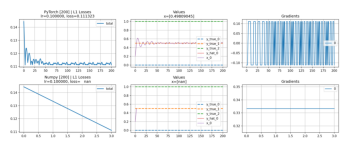

In [637]:
class func():
    def f(self, x):
        return x
    def df(self, x):
        return 1.0
class func_sin():
    def f(self, x):
        if x.dtype == 'float32':
            # numpy
            return math.sin(x)
        else:
            return torch.sin(x)
    def df(self, x):
        if x.dtype == 'float32':
            return math.cos(x)
        else:
            return torch.cos(x)

loss_type = 'L1'
e_terminate = 200
y_true = np.float32([0.0, 0.5, 1.0])
x_init = np.float32([0.2])
batch_size = len(y_true)
n_batch = len(y_true) // batch_size
print('n_batch:', n_batch, ', batch_size:', batch_size)
#x_init = 7.0*np.ones(2).astype(np.float32)
print('y_true={}, x_init={}'.format(y_true, x_init))
in_dict = {
    'device': device,
    'loss_type': loss_type,
    'func': func(),
    'y_true': y_true,
    'x_init': x_init,
    'n_batch': n_batch,
    'batch_size': batch_size
}
model = Model(in_dict)
model_np = ModelNumpy(in_dict)

out_dir = './23_data'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
out_dir += '/output'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    
now = datetime.now()
date_str = '{}{:>02}{:>02}'.format(now.year, now.month, now.day)
log_path = out_dir + '/log_{}.txt'.format(date_str)
__output_log(log_path, '=== {} Start ==========================\n'.format(date_str))

loop = tqdm_notebook(range(1000000000))
loop.set_description('start')


lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=1, verbose=False)

losses = {}
values = {}
gradients = {}

losses_np = {}
values_np = {}
gradients_np = {}

t0 = time.time()
for e in loop:
    optimizer.zero_grad()
    
    ls = {}
    vals = {}
    grads = {}
    
    ls_np = {}
    vals_np = {}
    grads_np = {}
    for batch_idx in range(n_batch):
        l, l_dict, v_dict = model(batch_idx)
        l_np, l_dict_np, v_dict_np = model_np.forward(batch_idx)
        for k, v in l_dict.items():
            if k not in ls:
                ls[k] = 0.0
                ls_np[k] = 0.0
                
            ls[k] += v / (n_batch * batch_size)
            ls_np[k] += l_dict_np[k] / (n_batch * batch_size)
            
        for k, v in v_dict.items():
            if k not in vals:
                vals[k] = 0.0
                vals_np[k] = 0.0
            vals[k] += v
            vals_np[k] += v_dict_np[k]
            
        l.backward()
    
        grad = model.x.grad.clone().detach().cpu().numpy()
        grad_np = model_np.backward_sgd(batch_idx, step_size=lr)

        for gi in range(len(grad)):
            if gi not in grads:
                grads[gi] = 0.0
                grads_np[gi] = 0.0
            grads[gi] += grad[gi] / (n_batch * batch_size)
            grads_np[gi] += grad_np[gi] / (n_batch * batch_size)
            
#         scheduler.step(l)
        
    optimizer.step()

    for k, v in ls.items():
        if k not in losses:
            losses[k] = []
            losses_np[k] = []
        losses[k].append(v)
        losses_np[k].append(ls_np[k])
        
    for k, v in vals.items():
        if k not in values:
            values[k] = []
            values_np[k] = []
        values[k].append(np.float32(v))
        values_np[k].append(np.float32(vals_np[k]))
    
    for gi in range(len(grads)):
        if gi not in gradients:
            gradients[gi] = []
            gradients_np[gi] = []
        gradients[gi].append(grads[gi])
        gradients_np[gi].append(grads_np[gi])
        
    # log
    lr_curr = optimizer.param_groups[0]['lr']
    loss_curr = losses['total'][-1]
    loop.set_description('[{}] batch[{}/{}] lr={:.4f}, loss={:.6f}\n'.format(e, batch_idx+1, model.n_batch, lr_curr, loss_curr))
    
    mb_alloc = torch.cuda.memory_allocated() * 0.000001
    mb_cached = torch.cuda.memory_cached() * 0.000001
    now = datetime.now()
    hour = str(now.hour)
    minute = str(now.minute)
    second = str(now.second)
    now_str = '{:>02}:{:>02}:{:>02}'.format(hour, minute, second)
    t1 = time.time()
    out_str = '{} | {:04} | {:.2f}s | lr={:.8f} | loss={:.6f} | GPU_allocated({:,.2f}Mb) | GPU_cached({:,.2f}Mb)\n'.format(now_str, e, t1-t0, lr_curr, loss_curr, mb_alloc, mb_cached)
    __output_log(log_path, out_str)
    
    if e % 10 == 0:
        if e == e_terminate:
            save_dir = out_dir
        else:
            save_dir = None
        img = plot_2(save_dir, model.loss_type, e, lr_curr, losses, values, gradients, losses_np, values_np, gradients_np)
    
    if e == e_terminate:
        plt.figure()
        plt.imshow(img)
        plt.axis(False)
        plt.show()
        break
    